# Ćwiczenie 3

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry Connect Four (czwórki).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four (ale, tak aby rozwiązanie miało ten sam interfejs co podany poniżej).

Implementację Minimax należy przetestować używając różną głębokość przeszukiwania. Implementacja Solvera musi zapewniać interfejs jak poniżej, ale można dodać dowolne metody prywatne oraz klasy wspomagające (jeżeli będą potrzebne).

Punktacja:
- Działająca metoda Minimax - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania **1.5pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów, bądź kilka przykładów 'z ręki'
- Jakość kodu **2pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/MinMax_algorytm')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from typing import Tuple, List

from connect_four_game.player import Player
from connect_four_game.connect_four import ConnectFour, ConnectFourMove

Wielkość planszy

In [ ]:
ROW_COUNT = 6
COLUMN_COUNT = 7

## Minimax kod

In [ ]:
from typing import Tuple, Optional
import sys
import collections

from connect_four_game.connect_four import ConnectFour, ConnectFourState
from connect_four_game.player import Player

sys.setrecursionlimit(5000)


class MinMaxSolver:
    def __init__(self):
        self.if_potencial_winner = None

    def evaluate_for_player(self, state: ConnectFourState, player: Player) -> int:
        if state.get_winner() == player:
            return 99999

        score = 0
        # Vertically
        for seq_length, num_of_seqs in self.count_vertical(state, player).items():
            score += 2 * seq_length**2 * num_of_seqs

        # Horizontally
        for seq_length, num_of_seqs in self.count_horizontal(state, player).items():
            score += 2 * seq_length**2 * num_of_seqs
            # Boosting nearly win situation
            if self.if_potencial_winner:
                score += 30
            self.if_potencial_winner = None

        # Diagonally NW - SE
        score += 54 * self.count_diagonal_NW_SE(state, player)

        # Diagonally NE - SW
        score += 54 * self.count_diagonal_NE_SW(state, player)

        # Booster
        score += self.count_in_center_column(state, player)

        return score

    def count_diagonal_NE_SW(self, state: ConnectFourState, player: Player) -> int:
        """Count number of 'threes' that have also empty field available
            in direction  from NE to SW"""
        counted = 0
        num_rows = len(state.fields[0])
        num_columns = len(state.fields)

        for col_index in range(num_columns - 1, 2, -1):
            for row_index in range(num_rows - 1, 2, -1):
                if self._check_diagonal(state, player, col_index, row_index, direction=1):
                    counted += 1
        return counted

    def count_diagonal_NW_SE(self, state: ConnectFourState, player: Player) -> int:
        """Count number of 'threes' that have also empty field available
           in direction from NW to SE"""
        counted = 0
        num_rows = len(state.fields[0])
        num_columns = len(state.fields)

        for col_index in range(num_columns - 3):
            for row_index in range(num_rows - 1, 2, -1):
                if self._check_diagonal(state, player, col_index, row_index, direction=-1):
                    counted += 1
        return counted

    def _check_diagonal(self, state: ConnectFourState, player: Player, col_start: int, row_start: int,
                        direction: int) -> bool:
        """
        Direction -1 = down and right
        Direction  1 = down and left
        """
        sequence = [state.fields[col_start - i * direction][row_start - i] for i in range(4)]
        if collections.Counter(sequence)[player] == 3 and None in sequence:
            return True
        return False

    def count_horizontal(self, state: ConnectFourState, player: Player) -> dict[int, int]:
        counter = {1: 0, 2: 0, 3: 0}

        num_rows = len(state.fields[0])
        num_columns = len(state.fields)
        for i in range(num_rows):
            row = [state.fields[j][i] for j in range(num_columns)]
            row_index = 0
            while row_index < len(row):
                if row[row_index] == player:
                    counted = self._count_horizontal(row, player, row_index)
                    is_none_on_left = row_index - 1 >= 0 and row[row_index - 1] is None
                    is_none_on_right = row_index + counted < len(row) and row[row_index + counted] is None
                    if counted in counter and (is_none_on_left or is_none_on_right):
                        counter[counted] += 1
                        self._indicate_potencial_winner_situation(counted, is_none_on_left, is_none_on_right)
                    row_index += counted
                else:
                    row_index += 1
        return counter

    def _count_horizontal(self, row: list[Optional[Player]], player: Player, start_index: int) -> int:
        counted = 0
        for i in range(start_index, len(row)):
            if row[i] == player:
                counted += 1
                continue
            else:
                break
        return counted

    def _indicate_potencial_winner_situation(self, counted: int, is_none_on_left: bool,
                                             is_none_on_right: bool) -> bool:
        if counted == 3 and is_none_on_left and is_none_on_right:
            self.if_potencial_winner = True
            return True
        return False

    def count_vertical(self, state: ConnectFourState, player: Player) -> dict[int, int]:
        counter = {1: 0, 2: 0, 3: 0}
        for column in state.fields:
            for j, field in enumerate(column):
                if field is None:
                    counted = self._count_vertical(player, column, j - 1)
                    if counted in counter:
                        counter[counted] += 1
        return counter

    def _count_vertical(self, player: Player, column: list[Optional[Player]], index) -> int:
        counted = 0
        while (index >= 0):
            if column[index] == player:
                counted += 1
                index -= 1
            else:
                break
        return counted

    def count_in_center_column(self, state: ConnectFourState, player: Player) -> int:
        center_column_index = len(state.fields) // 2
        counted_occur_in_center = sum([1 for field in state.fields[
            center_column_index] if field == player])

        if len(state.fields) % 2 == 0:
            counted_occur_in_center += sum([1 for field in state.fields[
                center_column_index - 1] if field == player])

        return counted_occur_in_center

    def _get_evaluation(self, state: ConnectFourState, if_max_player: bool) -> int:
        if not if_max_player:
            return self.evaluate_for_player(state, state._other_player) - self.evaluate_for_player(
                state, state._current_player)
        return self.evaluate_for_player(state, state._current_player) - self.evaluate_for_player(
            state, state._other_player)

    def minimax(self, state: ConnectFourState, depth: int, alpha: float, beta: float,
                if_max_player: bool) -> Tuple[int, ConnectFourState]:
        """Returns evaluation and state"""
        if depth == 0 or state.is_finished():
            return self._get_evaluation(state, if_max_player), state

        if if_max_player:
            max_eval = float('-inf')
            best_state = None
            for move in state.get_moves():
                new_state = state.make_move(move)
                evaluation = self.minimax(new_state, depth - 1, alpha, beta, False)[0]
                if evaluation > max_eval:
                    max_eval = evaluation
                    best_state = new_state
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break
            return max_eval, best_state
        else:
            min_eval = float('inf')
            best_state = None
            for move in state.get_moves():
                new_state = state.make_move(move)
                evaluation = self.minimax(new_state, depth - 1, alpha, beta, True)[0]
                if evaluation < min_eval:
                    min_eval = evaluation
                    best_state = new_state
                beta = min(beta, min_eval)
                if alpha >= beta:
                    break
            return min_eval, best_state


class MinMaxRunner():
    def __init__(self, game: ConnectFour):
        self.game = game
        self.MinMaxSolver = MinMaxSolver()

    def _get_best_move(self, best_next_state: ConnectFourState) -> Optional[int]:
        """Returns column index of the last made move"""
        for i, column in enumerate(best_next_state.fields):
            none_num = sum([1 for field in column if field is None])
            current_none_num = sum([1 for field in self.game.state.fields[i] if field is None])
            if none_num != current_none_num:
                return i
        return None

    def show_minimax_move(self, depth: int) -> Tuple[ConnectFourState, Player, int]:
        alpha = float('-inf')
        beta = float('inf')
        move_made_by = self.game.state.get_current_player()
        new_state = self.MinMaxSolver.minimax(self.game.state, depth, alpha, beta, True)[1]
        best_column_move = self._get_best_move(new_state)
        return new_state, move_made_by, best_column_move

    def make_minimax_move(self, depth: int) -> None:
        self.game.state = self.show_minimax_move(depth)[0]


## Testy Minimaxa

### Kod użyty do przetestowania czasu z obcinaniem alpha-beta i bez

In [ ]:
from connect_four_game.player import Player
from connect_four_game.connect_four import ConnectFour
from minimax import MinMaxRunner
import tests.process_times as process_times


p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(6, 7), first_player=p2, second_player=p1)
game.state.fields = [[None, None, None, None, None, None],
                     [p2, p2, p1, None, None, None],
                     [p2, p1, p2, None, None, None],
                     [p1, p2, p1, p2, p1, p2],
                     [p2, None, None, None, None, None],
                     [p2, p1, None, None, None, None],
                     [p1, None, None, None, None, None]]
runner = MinMaxRunner(game)

print(process_times.get_time(runner.show_minimax_move, 6))


### Obliczony czas podjęcia decyzji w środku rozgrywki z głębokościa 6:
- dla minimaxa z obcinaniem ~ 0.046875 s
- dla minimaxa bez obcinania ~ 6.03125 s

### Obcinanie alpha-beta może znacznie obniżyć czas podjęcia decyzji dla dużych głębokości

## Testowanie funkcji potrzebnych do ewaluacji stanu gry

In [ ]:
from connect_four_game.player import Player
from connect_four_game.connect_four import ConnectFour, ConnectFourMove
from minimax import MinMaxSolver

ROW_COUNT = 6
COLUMN_COUNT = 7


def test_count_at_center():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][b][a][a][ ][ ][ ]
    [ ][b][a][b][ ][a][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p2, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p2, p1, p2, p1, None],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_in_center_column(game.state, p1) == 3
    assert solver.count_in_center_column(game.state, p2) == 2


def test_count_horizontal():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][b][a][a][ ][ ][ ]
    [ ][b][a][b][ ][a][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p2, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p2, p1, p2, p1, None],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_horizontal(game.state, p1) == {1: 3, 2: 2, 3: 0}
    assert solver.count_horizontal(game.state, p2) == {1: 4, 2: 1, 3: 0}


def test_count_vertical():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][b][a][a][ ][ ][ ]
    [ ][b][a][b][ ][a][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p2, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p2, p1, p2, p1, None],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_vertical(game.state, p1) == {1: 2, 2: 2, 3: 0}
    assert solver.count_vertical(game.state, p2) == {1: 0, 2: 0, 3: 1}


def test_nearly_win_situation_indication():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][a][a][a][ ][ ][ ]
    [ ][b][a][b][ ][a][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p1, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p2, p1, p2, p1, None],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    solver.count_horizontal(game.state, p1)
    assert solver.if_potencial_winner


def test_count_diagonal_NW_SE_none_top_left():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][a][ ][b][ ][ ][ ]
    [ ][a][a][a][ ][ ][ ]
    [ ][b][a][a][ ][a][ ]
    [ ][b][b][a][b][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p1, p1, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p1, p1, p2, p1, None],
                         [p2, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_diagonal_NW_SE(game.state, p1) == 2


def test_count_diagonal_NW_SE_none_right_bottom():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [b][ ][ ][ ][ ][ ][ ]
    [a][a][ ][ ][ ][ ][ ]
    [a][a][a][ ][ ][ ][ ]
    [b][b][a][ ][ ][a][ ]
    [a][b][b][ ][b][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[p1, p2, p1, p1, p2, None],
                         [p2, p2, p1, p1, None, None],
                         [p2, p1, p1, None, None, None],
                         [None, None, None, None, None, None],
                         [p2, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_diagonal_NW_SE(game.state, p1) == 1


def test_count_diagonal_NW_SE_double_case():
    """
    Characteristic case
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][ ]
    [a][a][ ][ ][ ][ ][ ]
    [a][b][a][ ][ ][ ][ ]
    [b][b][a][a][ ][a][ ]
    [a][b][b][b][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[p1, p2, p1, p1, None, None],
                         [p2, p2, p2, p1, None, None],
                         [p2, p1, p1, None, None, None],
                         [p2, p1, None, None, None, None],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    solver = MinMaxSolver()
    # One diagonal is counted as two but it's ok
    # It is a better case than just one ordinary one
    assert solver.count_diagonal_NW_SE(game.state, p1) == 2


def test_count_diagonal_NE_SW_none_top_right():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][a]
    [ ][ ][a][ ][ ][a][b]
    [ ][ ][a][ ][a][b][b]
    [ ][ ][b][ ][b][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[None, None, None, None, None, None],
                         [None, None, None, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [None, None, None, None, None, None],
                         [p2, p1, None, None, None, None],
                         [p1, p2, p1, None, None, None],
                         [p1, p2, p2, p1, None, None]]
    solver = MinMaxSolver()
    assert solver.count_diagonal_NE_SW(game.state, p1) == 1


def test_count_diagonal_NE_SW_none_left_bottom():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][a][ ][ ][a][b]
    [ ][ ][a][ ][a][b][b]
    [ ][ ][b][a][b][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[None, None, None, None, None, None],
                         [None, None, None, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, None, None, None, None, None],
                         [p2, p1, None, None, None, None],
                         [p1, p2, p1, None, None, None],
                         [p1, p2, p2, None, None, None]]
    solver = MinMaxSolver()
    assert solver.count_diagonal_NE_SW(game.state, p1) == 1


def test_count_diagonal_NE_SW_double_case():
    """
    Characteristic case
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][ ][ ][a][ ]
    [ ][a][ ][ ][a][b][ ]
    [ ][a][ ][a][b][b][ ]
    [ ][b][a][b][a][a][ ]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [None, None, None, None, None, None],
                         [p2, p1, None, None, None, None],
                         [p1, p2, p1, None, None, None],
                         [p1, p2, p2, p1, None, None],
                         [None, None, None, None, None, None]]
    solver = MinMaxSolver()
    # One diagonal is counted as two but it's ok
    # It is a better case than just one ordinary one
    assert solver.count_diagonal_NE_SW(game.state, p1) == 2


## Testowanie niektórych decyzji podejmowanych przez Minimaxa

In [ ]:
from connect_four_game.player import Player
from connect_four_game.connect_four import ConnectFour
from minimax import MinMaxRunner

ROW_COUNT = 6
COLUMN_COUNT = 7


def test_simple_choice_going_for_win():
    """
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][b][a][b][ ][ ][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, None, None, None, None],
                         [p2, p1, None, None, None, None],
                         [p1, p2, p1, p2, p1, p2],
                         [None, None, None, None, None, None],
                         [p1, None, None, None, None, None],
                         [p1, None, None, None, None, None]]
    runner = MinMaxRunner(game)
    assert (p1, 4) == runner.show_minimax_move(1)[1:]
    assert (p1, 4) == runner.show_minimax_move(2)[1:]
    assert (p1, 4) == runner.show_minimax_move(3)[1:]
    assert (p1, 4) == runner.show_minimax_move(4)[1:]
    assert (p1, 4) == runner.show_minimax_move(5)[1:]


def test_simple_choice_going_for_win2():
    """
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][b][a][a][ ][ ][ ]
    [ ][b][a][b][ ][a][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, p2, None, None, None],
                         [p2, p1, p1, None, None, None],
                         [p1, p2, p1, p2, p1, p2],
                         [None, None, None, None, None, None],
                         [p1, p1, None, None, None, None],
                         [p1, None, None, None, None, None]]
    runner = MinMaxRunner(game)
    assert (p2, 1) == runner.show_minimax_move(1)[1:]
    assert (p2, 1) == runner.show_minimax_move(2)[1:]
    assert (p2, 1) == runner.show_minimax_move(3)[1:]
    assert (p2, 1) == runner.show_minimax_move(4)[1:]
    assert (p2, 1) == runner.show_minimax_move(5)[1:]


def test_tournament_simple():
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    runner = MinMaxRunner(game)

    while True:
        runner.make_minimax_move(3)
        if game.state.is_finished():
            break
        runner.make_minimax_move(1)
        if game.state.is_finished():
            break

    assert game.state.get_winner() == p1


def test_tournament():
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    runner = MinMaxRunner(game)

    while True:
        runner.make_minimax_move(5)
        if game.state.is_finished():
            break
        runner.make_minimax_move(2)
        if game.state.is_finished():
            break

    assert game.state.get_winner() == p1


def test_tournament2():
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    runner = MinMaxRunner(game)

    while True:
        runner.make_minimax_move(3)
        if game.state.is_finished():
            break
        runner.make_minimax_move(4)
        if game.state.is_finished():
            break

    assert game.state.get_winner() == p2


def test_tournament_same_depths():
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    runner = MinMaxRunner(game)

    while True:
        runner.make_minimax_move(3)
        if game.state.is_finished():
            break
        runner.make_minimax_move(3)
        if game.state.is_finished():
            break

    # Winner is the one who started
    assert game.state.get_winner() == p1


def test_blocking():
    """
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][b][ ][b][ ][ ][ ]
    [ ][b][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p2, p2, None, None, None, None],
                         [p2, None, None, None, None, None],
                         [p1, p2, p1, p1, p1, p2],
                         [None, None, None, None, None, None],
                         [p1, None, None, None, None, None],
                         [p1, None, None, None, None, None]]
    runner = MinMaxRunner(game)
    assert (p2, 4) == runner.show_minimax_move(5)[1:]
    runner.make_minimax_move(5)
    assert (p1, 2) == runner.show_minimax_move(5)[1:]


def test_blocking2():
    """
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][a][a][ ][ ][ ]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [None, None, None, None, None, None],
                         [p1, None, None, None, None, None],
                         [p1, p2, p1, p1, p1, p2],
                         [None, None, None, None, None, None],
                         [None, None, None, None, None, None],
                         [None, None, None, None, None, None]]
    runner = MinMaxRunner(game)
    assert runner.show_minimax_move(5)[1:] in [(p2, 1), (p2, 4)]


def test_blocking3():
    """
    [ ][ ][ ][ ][ ][ ][ ]
    [ ][ ][ ][a][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][ ][ ][b][ ][ ][ ]
    [ ][a][b][a][ ][a][a]
    """
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    game.state.fields = [[None, None, None, None, None, None],
                         [p1, None, None, None, None, None],
                         [p2, None, None, None, None, None],
                         [p1, p2, p2, p2, p1, None],
                         [None, None, None, None, None, None],
                         [p1, None, None, None, None, None],
                         [p1, None, None, None, None, None]]
    runner = MinMaxRunner(game)
    assert (p2, 4) == runner.show_minimax_move(5)[1:]


def test_first_move():
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
    runner = MinMaxRunner(game)
    assert (p2, 3) == runner.show_minimax_move(5)[1:]


## Kod użyty do testowania ile razy minimax z daną głębokościa wygra przeciwko graczowi, który podejmuje losowe decyzje

In [ ]:
import random

import plot
from connect_four_game.player import Player
from connect_four_game.connect_four import ConnectFour
from minimax import MinMaxRunner

ROW_COUNT = 6
COLUMN_COUNT = 7


def check_minimax(number: int, depth: int) -> list[int, int, int]:
    wins = 0
    loses = 0
    draws = 0
    for _ in range(number):
        p1 = Player("a")
        p2 = Player("b")
        if random.randint(1, 2) == 1:
            game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
        else:
            game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p2, second_player=p1)
        runner = MinMaxRunner(game)

        while not game.is_finished():
            if game.state.get_current_player() == p1:
                runner.make_minimax_move(depth)
                continue

            if game.state.get_current_player() == p2:
                moves = game.get_moves()
                move = random.choice(moves)
                game.make_move(move)
                continue

        if game.state.get_winner() == p1:
            wins += 1
        elif game.state.get_winner() == p2:
            loses += 1
        else:
            draws += 1
    return wins, loses, draws


if __name__ == "__main__":
    wins, loses, draws = check_minimax(40, 2)
    plot.configurate_plot("Results", "Number of wins", "Minimax depth 2 vs random player",
                          window_title="Minimax")
    plot.make_bar_plot(["wins", "loses", "draws"], [wins, loses, draws],
                       color=plot.PLOT_CYAN)
    plot.show_plot()


## Wyniki testów

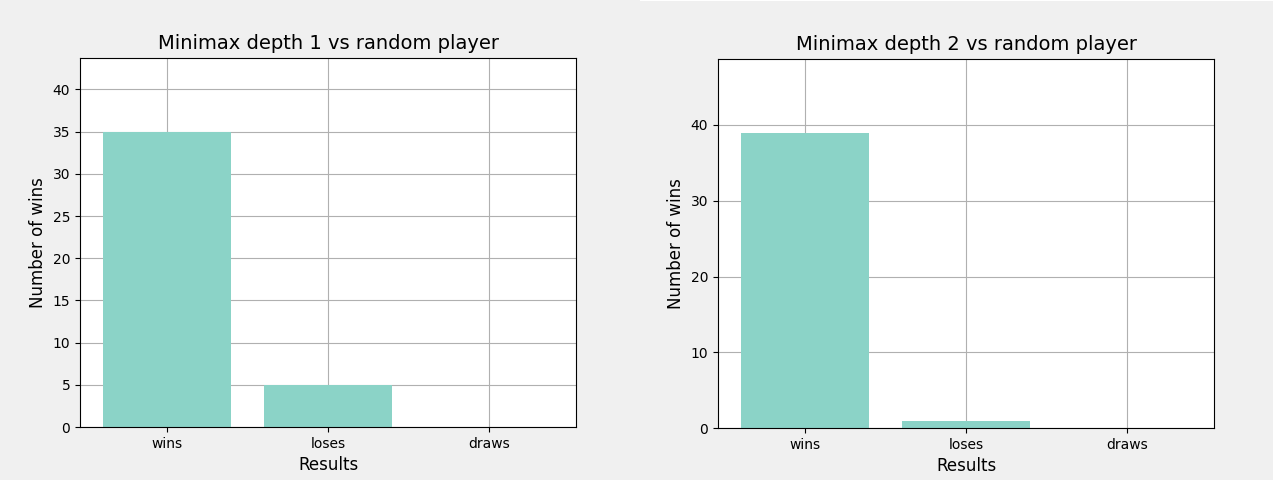

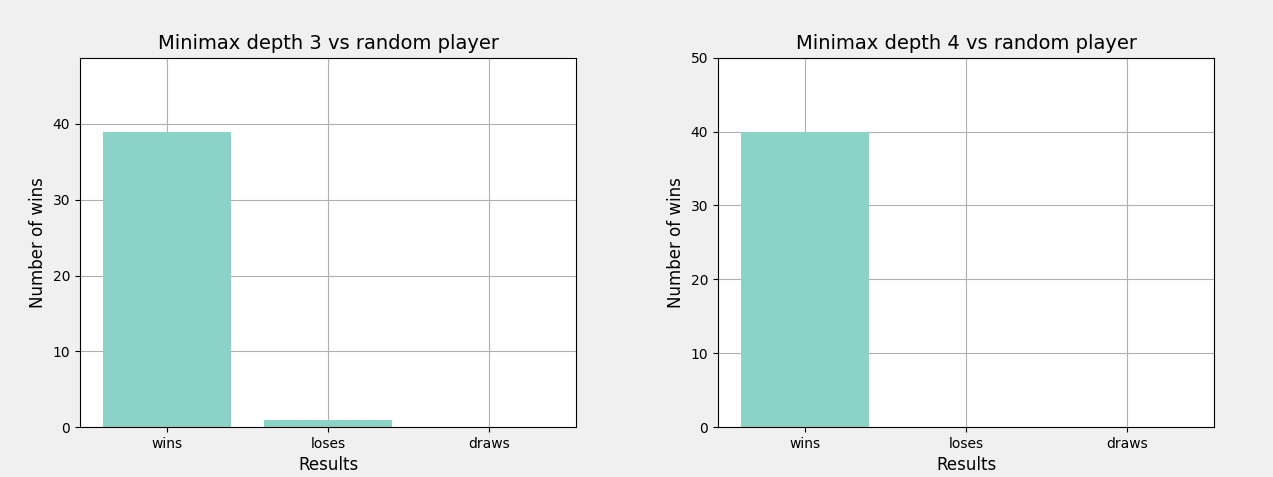

## Inne obserwacje (na podstawie widocznych wcześniej testów do minimaxa)

- w przetestowanych przypadkach, bot vs bot, wygrywał ten bot, który miał większą głębokość w minimaxie
- w przetestowanych przypadkach, bot vs bot o takich samych głebokościach w minimaxie, wygrywał ten bot, który wykonywał pierwszy ruch